In [7]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import copy

import scoobpsf
import scoobpsf.ad_scoob as ad_scoob
import scoobpsf.props as props
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3

import lina

from importlib import reload

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle

from scipy.signal import windows
from scipy.optimize import minimize

wavelength_c = 650e-9*u.m
wavelength = 650e-9*u.m
pupil_diam = 9.4*u.mm
lyot_stop_diam = 8.6*u.mm
im_fl = 280*u.mm
um_per_lamD = (wavelength_c*im_fl/(lyot_stop_diam)).to(u.um)
psf_pixelscale = 3.76*u.um/u.pix
psf_pixelscale_lamD = (psf_pixelscale / um_per_lamD).decompose().value

crad = 34/2 * 9.4/10.2 * 8.6/9.4

npix = 1000
oversample = 2.048
N = int(npix*oversample)
npsf = 200

nlyot = int(np.ceil(lyot_stop_diam/pupil_diam * npix))
if nlyot%2==1:
    nlyot += 1
print(nlyot)

Nact = 34
act_spacing = 0.3*u.mm
inf_sampling = (npix/pupil_diam * act_spacing).value
print(inf_sampling)

916
31.914893617021274


# Establish the forward model parameters.

916


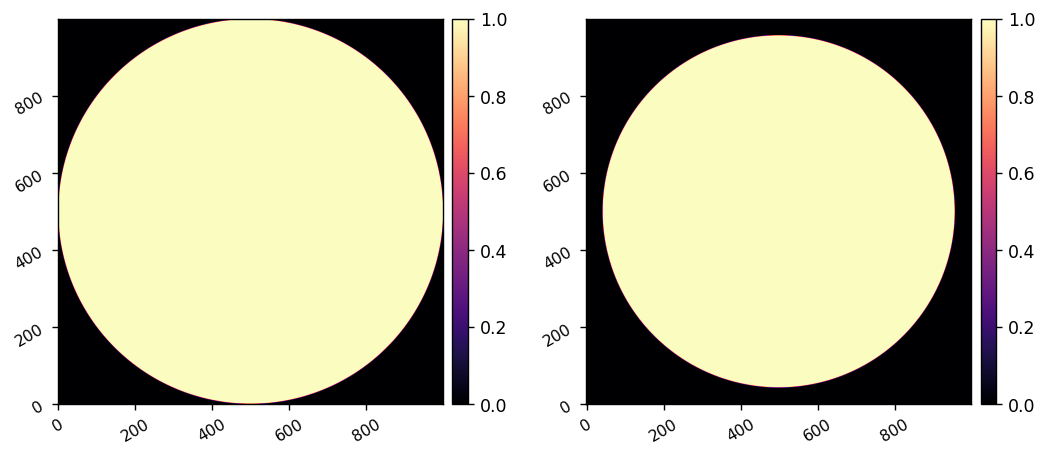

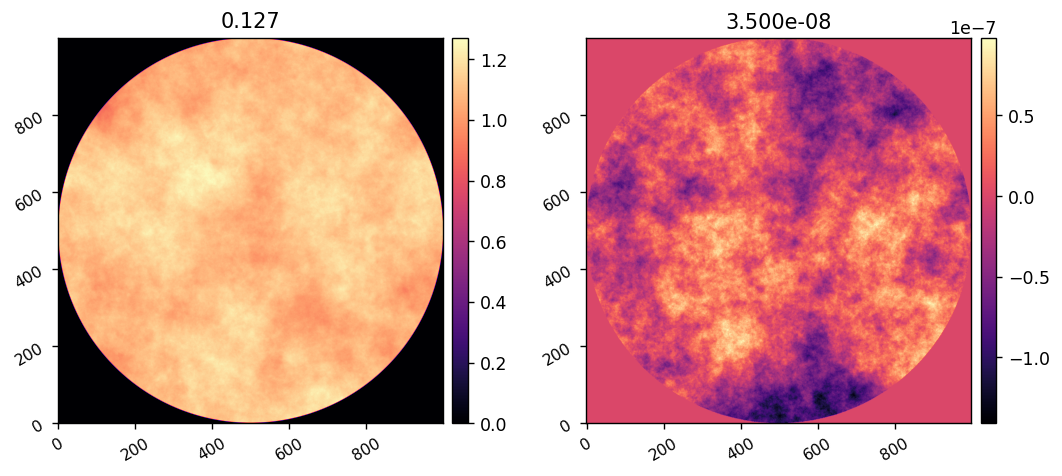

In [3]:
npix = 1000
oversample = 2.048
N = int(npix*oversample)

nlyot = int(np.ceil(lyot_stop_diam/pupil_diam * npix))
if nlyot%2==1:
    nlyot += 1
print(nlyot)

import poppy
pwf = poppy.FresnelWavefront(beam_radius=pupil_diam/2, npix=npix, oversample=1) # pupil wavefront
APERTURE = poppy.CircularAperture(radius=pupil_diam/2).get_transmission(pwf)
LYOT = poppy.CircularAperture(radius=lyot_stop_diam/2).get_transmission(pwf)
imshow2(APERTURE, LYOT)

reload(utils)
WFE, mask = utils.generate_wfe(diam=pupil_diam,
                                npix=npix, oversample=1,
                                wavelength=wavelength,
                                opd_index=2.75, amp_index=3,
                                opd_rms=35*u.nm, amp_rms=0.05,
                                # opd_seed=12, amp_seed=1234,
                                remove_modes=12)

wfe_amp = xp.abs(WFE)
wfe_opd = xp.angle(WFE)*wavelength.to_value(u.m)/2/np.pi
rms_amp = xp.sqrt(xp.mean(xp.square(wfe_amp[mask]-1)))
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[mask])))
imshow2(wfe_amp, wfe_opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')

### Initialize DM parameters

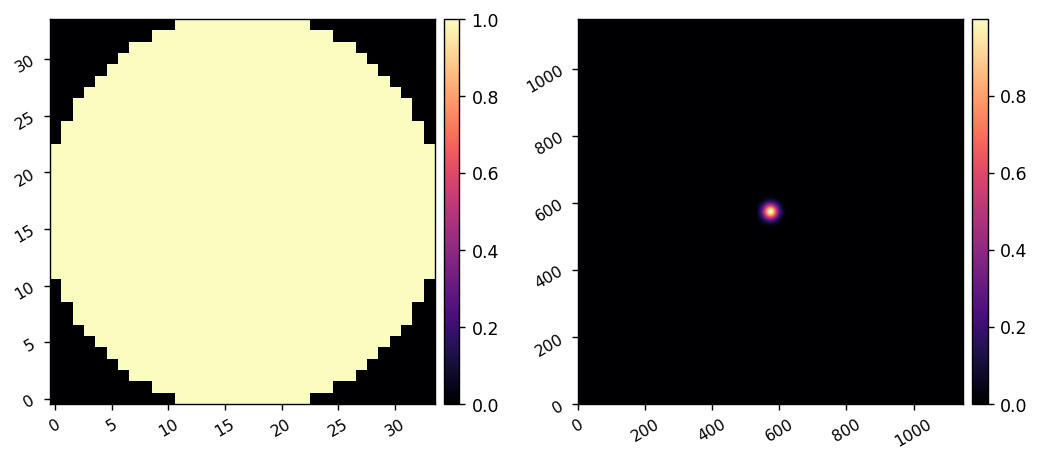

In [11]:
reload(ad_scoob)

dm_mask = ad_scoob.make_dm_mask(Nact)
Nacts = int(dm_mask.sum())
inf_fun = ad_scoob.make_gaussian_inf_fun(act_spacing=act_spacing, sampling=inf_sampling, 
                                         Nacts_per_inf=Nact + 2, # number of influence functions across the grid
                                         coupling=0.15,)
Nsurf = inf_fun.shape[0]
imshow2(dm_mask, inf_fun)

inf_matrix = ad_scoob.make_inf_matrix(inf_fun, inf_sampling, dm_mask)

### Initialize vortex mask parameters.

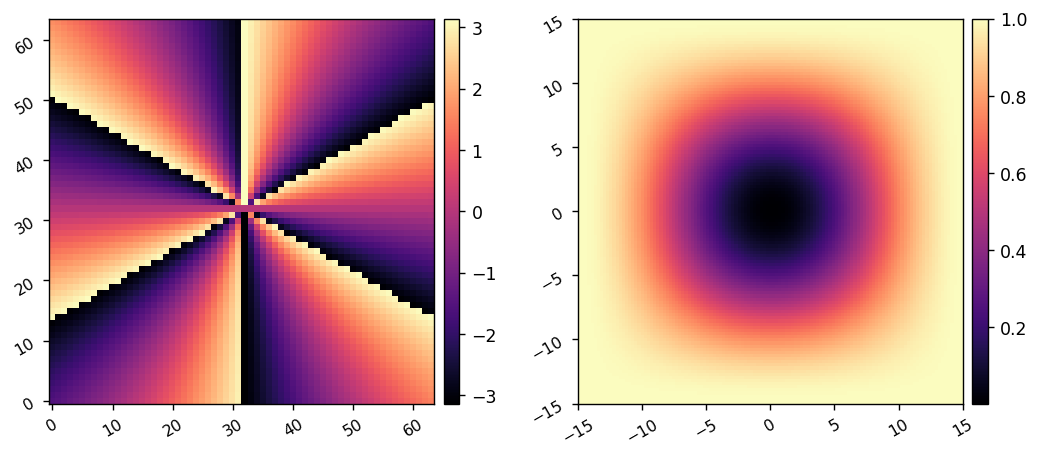

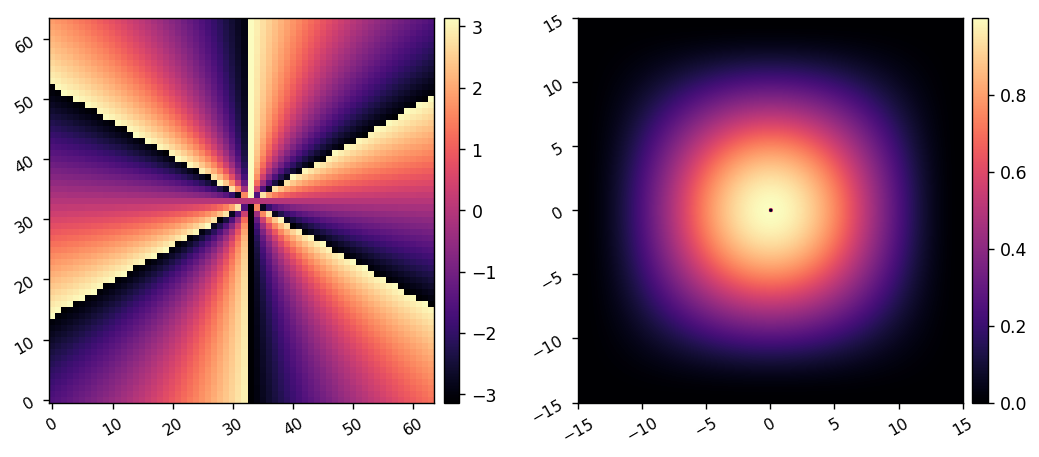

In [6]:
oversample_vortex = 4.096
N_vortex_lres = int(npix*oversample_vortex)
lres_sampling = 1/oversample_vortex # low resolution sampling in lam/D per pixel
lres_win_size = int(30/lres_sampling) + 1
w1d = xp.array(windows.tukey(lres_win_size, 1, False))
lres_window = utils.pad_or_crop(xp.outer(w1d, w1d), N_vortex_lres)
vortex_lres = props.make_vortex_phase_mask(N_vortex_lres)
imshow2(xp.angle(vortex_lres), 1-lres_window, npix1=64, npix2=lres_win_size, pxscl2=lres_sampling)

hres_sampling = 0.025 # lam/D per pixel; this value is chosen empirically
N_vortex_hres = int(np.round(30/hres_sampling))
hres_win_size = int(30/hres_sampling)
N_vortex_hres = int(np.round(30.029296875/hres_sampling))
hres_win_size = int(30.029296875/hres_sampling)
w1d = xp.array(windows.tukey(hres_win_size, 1, False))
hres_window = utils.pad_or_crop(xp.outer(w1d, w1d), N_vortex_hres)
vortex_hres = props.make_vortex_phase_mask(N_vortex_hres)

x = (xp.linspace(-N_vortex_hres//2, N_vortex_hres//2-1, N_vortex_hres)) * hres_sampling
x,y = xp.meshgrid(x,x)
r = xp.sqrt(x**2 + y**2)
sing_mask = r>=0.15
hres_window *= sing_mask
imshow2(xp.angle(vortex_hres), hres_window, npix1=64, npix2=hres_win_size, pxscl2=hres_sampling)

# psf_pixelscale_lamD = 0.17
# npsf = 200

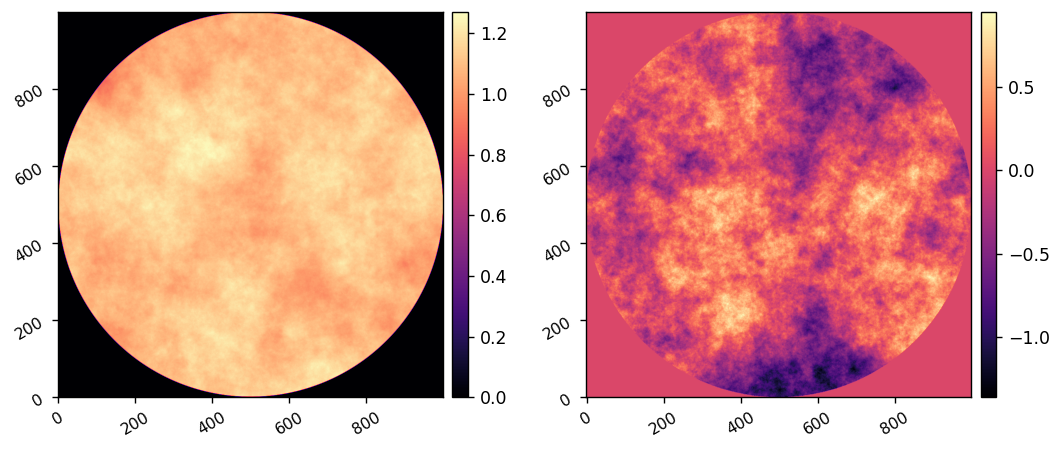

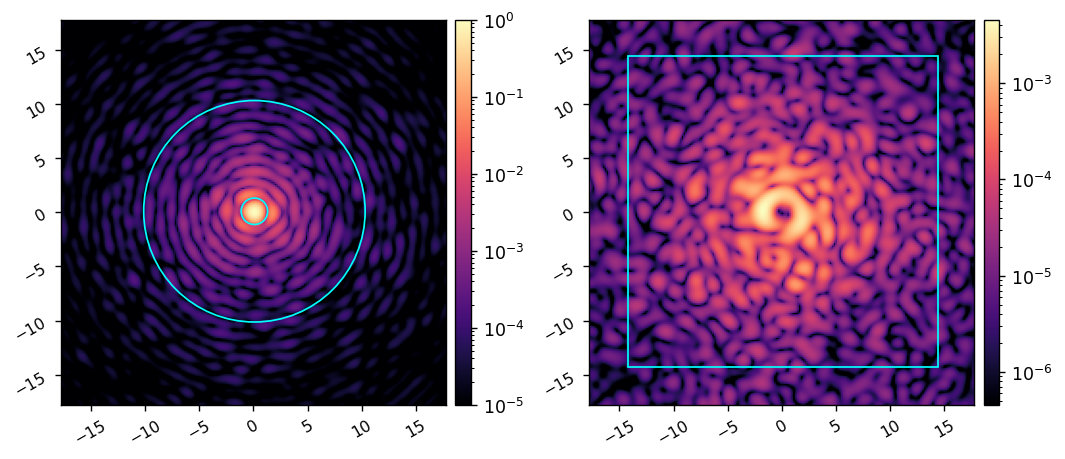

In [16]:
reload(props)
def forward_model(actuators, use_vortex=True, use_wfe=True, return_pupil=False):
    dm_surf = inf_matrix.dot(xp.array(actuators)).reshape(Nsurf,Nsurf)
    dm_phasor = xp.exp(1j * 4*xp.pi/wavelength.to_value(u.m) * dm_surf)

    wf = utils.pad_or_crop(APERTURE, N).astype(xp.complex128)
    wf *= utils.pad_or_crop(dm_phasor, N)
    # imshow2(xp.abs(wf), xp.angle(wf), npix=npix)

    if use_wfe: 
        wf *= utils.pad_or_crop(WFE, N)
        # imshow2(xp.abs(wf), xp.angle(wf), npix=npix)

    if return_pupil:
        E_pup = copy.copy(wf)

    if use_vortex:
        lres_wf = utils.pad_or_crop(wf, N_vortex_lres) # pad to the larger array for the low res propagation
        fp_wf_lres = xp.fft.ifftshift(xp.fft.fft2(xp.fft.fftshift(lres_wf))) # to FPM
        fp_wf_lres *= vortex_lres * (1 - lres_window) # apply low res (windowed) FPM
        pupil_wf_lres = xp.fft.fftshift(xp.fft.ifft2(xp.fft.ifftshift(fp_wf_lres))) # to Lyot Pupil
        # pupil_wf_lres = utils.pad_or_crop(pupil_wf_lres, N)

        hres_wf = utils.pad_or_crop(wf, npix) # crop to the pupil diameter for the high res propagation
        fp_wf_hres = props.mft_forward(hres_wf, hres_sampling, N_vortex_hres)
        fp_wf_hres *= vortex_hres * hres_window # apply high res (windowed) FPM
        # pupil_wf_hres = props.mft_reverse(fp_wf_hres, hres_sampling, npix,)
        # pupil_wf_hres = utils.pad_or_crop(pupil_wf_hres, N)
        pupil_wf_hres = props.mft_reverse(fp_wf_hres, hres_sampling*oversample_vortex, N_vortex_lres,)

        wf = (pupil_wf_lres + pupil_wf_hres)
        wf = utils.pad_or_crop(wf, N)
        # imshow2(xp.abs(wf), xp.angle(wf))

    wf *= utils.pad_or_crop(LYOT, N)
    # imshow2(xp.abs(wf), xp.angle(wf), npix=2*npix)

    wf = utils.pad_or_crop(wf, nlyot)
    fpwf = props.mft_forward(wf, psf_pixelscale_lamD, npsf)

    if return_pupil:
        return fpwf, E_pup
    else:
        return fpwf

acts = np.zeros(Nacts)

# waffle_command = 10e-9 * xp.ones((Nact,Nact))
# waffle_command[1::2, ::2] *= -1
# waffle_command[::2, 1::2] *= -1
# acts = ensure_np_array(waffle_command[dm_mask]) 

print()
psf_wf, E_pup = forward_model(acts, 
                              use_vortex=False, 
                            #   use_wfe=False, 
                              return_pupil=True,
                              )
coro_wf = forward_model(acts, 
                        # use_wfe=False,
                        )


psf = xp.abs(psf_wf)**2
ref_coro_im = xp.abs(coro_wf)**2
I_max_ref = xp.max(psf)

psf /= I_max_ref
ref_coro_im /= I_max_ref

imshow2(xp.abs(E_pup), xp.angle(E_pup), npix=npix)
imshow2(psf, ref_coro_im, 
        pxscl=psf_pixelscale_lamD, 
        patches1=[Circle((psf_pixelscale_lamD/2,psf_pixelscale_lamD/2), 1.22, fill=False, color='cyan'),
                  Circle((psf_pixelscale_lamD/2,psf_pixelscale_lamD/2), 10.22, fill=False, color='cyan')],
        patches2=[Rectangle((-crad+psf_pixelscale_lamD/2, -crad+psf_pixelscale_lamD/2), crad*2, crad*2, fill=False, color='cyan', )],
        lognorm=True, vmin1=1e-5, vmin2=xp.max(ref_coro_im)/1e4)

# Test minimzation with L-BFGS-B

In [35]:
def val_and_grad(del_acts, E_ab, E_target=0, E_model_nom=0, r_cond=1e-2, verbose=False):
    # Convert array arguments into GPU arrays if necessary
    E_ab = xp.array(E_ab) 
    E_model_nom = xp.array(E_model_nom)
    E_target = xp.array(E_target)
    
    E_ab_l2norm = E_ab[control_mask].dot(E_ab[control_mask].conjugate()).real

    # Compute E_dm using the forward DM model
    E_dm = forward_model(del_acts, use_vortex=True, use_wfe=False) / xp.sqrt(I_max_ref) # make sure to do the array indexing
    E_dm = E_dm - E_model_nom
    # imshow2(xp.abs(E_dm), xp.angle(E_dm))

    # compute the cost function
    delE = E_ab + E_dm - E_target
    delE_vec = delE[control_mask] # make sure to do array indexing
    J_delE = delE_vec.dot(delE_vec.conjugate()).real
    M_tik = r_cond * np.eye(Nacts, Nacts)
    c = M_tik.dot(del_acts) # I think I am doing something wrong with M_tik
    J_c = c.dot(c)
    if E_ab_l2norm>1e-8:
        J = (J_delE + J_c) / E_ab_l2norm
    else: 
        J = (J_delE + J_c)
    if verbose: print(J_delE, J_c, E_ab_l2norm, J)

    # Compute the gradient with the adjoint model
    delE_masked = control_mask * delE # still a 2D array
    dJ_dE_dm = 2 * delE_masked / E_ab_l2norm
    dJ_dE_ls = props.mft_reverse(dJ_dE_dm, psf_pixelscale_lamD, nlyot)
    dJ_dE_ls = utils.pad_or_crop(dJ_dE_ls, npix)
    dJ_dE_lp = LYOT * dJ_dE_ls
    # imshow2(xp.abs(dJ_dE_lp), xp.angle(dJ_dE_lp))

    # Now we have to split and back-propagate the gradient along the two branches 
    # used to model the vortex. So one branch for the FFT vortex procedure and one 
    # for the MFT vortex procedure. 
    dJ_dE_lp_fft = utils.pad_or_crop(copy.copy(dJ_dE_lp), N_vortex_lres)
    dJ_dE_fpm_fft = xp.fft.fftshift(xp.fft.fft2(xp.fft.ifftshift(dJ_dE_lp_fft)))
    dJ_dE_fp_fft = vortex_lres.conjugate() * (1 - lres_window) * dJ_dE_fpm_fft
    dJ_dE_pup_fft = xp.fft.ifftshift(xp.fft.ifft2(xp.fft.fftshift(dJ_dE_fp_fft)))
    dJ_dE_pup_fft = utils.pad_or_crop(dJ_dE_pup_fft, N)
    # imshow2(xp.abs(dJ_dE_pup_fft), xp.angle(dJ_dE_pup_fft), npix=1*npix)

    dJ_dE_lp_mft = utils.pad_or_crop(copy.copy(dJ_dE_lp), N_vortex_lres)
    dJ_dE_fpm_mft = props.mft_forward(dJ_dE_lp_mft, hres_sampling*oversample_vortex, N_vortex_hres)
    # dJ_dE_lp_mft = utils.pad_or_crop(copy.copy(dJ_dE_lp), nlyot)
    # dJ_dE_fpm_mft = props.mft_forward(dJ_dE_lp_mft, hres_sampling, N_vortex_hres)
    dJ_dE_fp_mft = vortex_hres.conjugate() * hres_window * dJ_dE_fpm_mft
    # dJ_dE_pup_mft = props.mft_reverse(dJ_dE_fp_mft, hres_sampling, npix,)
    dJ_dE_pup_mft = props.mft_reverse(dJ_dE_fp_mft, hres_sampling*oversample, N,)
    # dJ_dE_pup_mft = utils.pad_or_crop(dJ_dE_pup_mft, N)
    # imshow2(xp.abs(dJ_dE_pup_mft), xp.angle(dJ_dE_pup_mft), npix=1*npix)

    dJ_dE_pup = dJ_dE_pup_fft + dJ_dE_pup_mft
    # imshow2(xp.abs(dJ_dE_pup), xp.angle(dJ_dE_pup), npix=1*npix)

    dJ_dS_dm = 4*xp.pi / wavelength.to_value(u.m) * xp.imag(E_pup.conjugate()/xp.sqrt(I_max_ref) * dJ_dE_pup)

    # Now pad back to the array size fo the DM surface to back propagate through the adjoint DM model
    dJ_dS_dm = utils.pad_or_crop(dJ_dS_dm, Nsurf)
    dJ_dA = inf_matrix.T.dot(dJ_dS_dm.flatten())
    
    return ensure_np_array(J), ensure_np_array(dJ_dA)

0.326070039171832 0.0 0.326070039171832 1.0


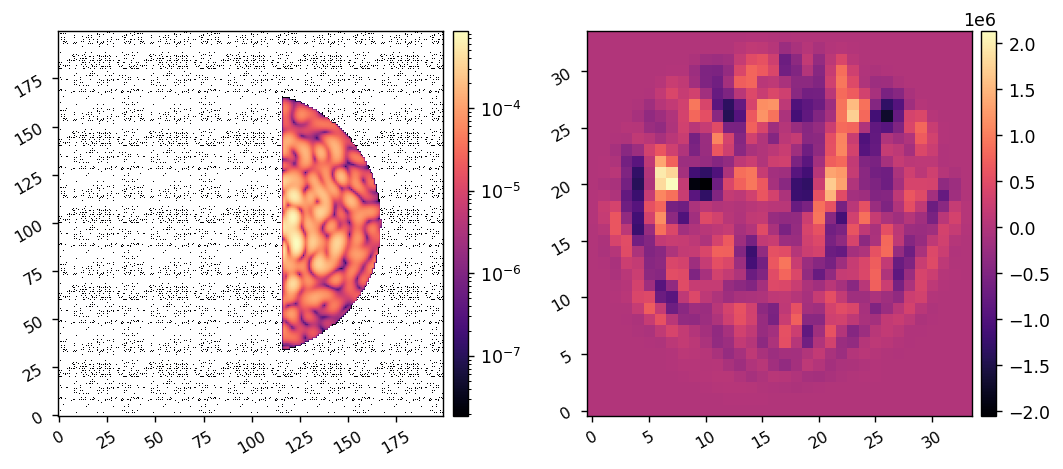

In [36]:
control_mask = ad_scoob.create_control_mask(npsf, psf_pixelscale_lamD, iwa=3, owa=12, edge=3, rotation=0)

del_acts = np.zeros(Nacts)
E_ab = ensure_np_array(forward_model(xp.zeros(Nacts), use_vortex=True, use_wfe=True) * control_mask / xp.sqrt(I_max_ref))
E_target = 0
E_model_nom = ensure_np_array(forward_model(xp.zeros((Nacts)), use_vortex=True, use_wfe=False) / xp.sqrt(I_max_ref))
r_cond = 1e-2

J, dJ_dA = val_and_grad(del_acts, 
                        E_ab,
                        E_target=E_target, 
                        E_model_nom=E_model_nom,
                        r_cond=r_cond,
                        verbose=True,
                        )

dm_grad = xp.zeros((Nact,Nact))
dm_grad[dm_mask] = dJ_dA
imshow2(control_mask*ref_coro_im, dm_grad, lognorm1=True)

In [37]:
del_acts = np.zeros(Nacts)
E_ab = ensure_np_array(forward_model(xp.zeros(Nacts), use_vortex=True, use_wfe=True) * control_mask / xp.sqrt(I_max_ref))
E_target = 0
E_model_nom = ensure_np_array(forward_model(xp.zeros((Nacts)), use_vortex=True, use_wfe=False) / xp.sqrt(I_max_ref))
r_cond = 1e-2

bfgs_tol = 1e-3
bfgs_opts = {
    'maxiter':20,
    # 'maxls':30, # default is 20
    'ftol':1e-6, 
    'gtol':1e-6,
    'disp':True, 
}

del_acts0 = np.zeros(Nacts)
res = minimize(val_and_grad, 
                jac=True, 
                x0=del_acts0,
                args=(E_ab, E_target, E_model_nom, r_cond), 
                method='L-BFGS-B',
                #    method='CG',
                tol=bfgs_tol,
                options=bfgs_opts,
                )
    

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          952     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  2.12989D+06


 This problem is unconstrained.



At iterate    1    f=  3.13203D-01    |proj g|=  1.15315D+06

At iterate    2    f=  1.19270D-01    |proj g|=  5.74467D+05

At iterate    3    f=  6.67629D-02    |proj g|=  4.79208D+05

At iterate    4    f=  3.69143D-02    |proj g|=  4.45705D+05

At iterate    5    f=  2.68644D-02    |proj g|=  3.98460D+05

At iterate    6    f=  1.54320D-02    |proj g|=  2.15820D+05

At iterate    7    f=  1.00927D-02    |proj g|=  9.32423D+04

At iterate    8    f=  8.46000D-03    |proj g|=  8.70000D+04

At iterate    9    f=  6.95159D-03    |proj g|=  1.79252D+05

At iterate   10    f=  5.31550D-03    |proj g|=  8.10389D+04

At iterate   11    f=  4.80374D-03    |proj g|=  1.50225D+05

At iterate   12    f=  4.11872D-03    |proj g|=  1.07695D+05

At iterate   13    f=  3.96909D-03    |proj g|=  8.77199D+04

At iterate   14    f=  3.72030D-03    |proj g|=  1.17521D+05

At iterate   15    f=  3.40995D-03    |proj g|=  8.85123D+04

At iterate   16    f=  2.84483D-03    |proj g|=  6.78391D+04

At iter

6.668098960569161e-05 1.857816783084087e-05


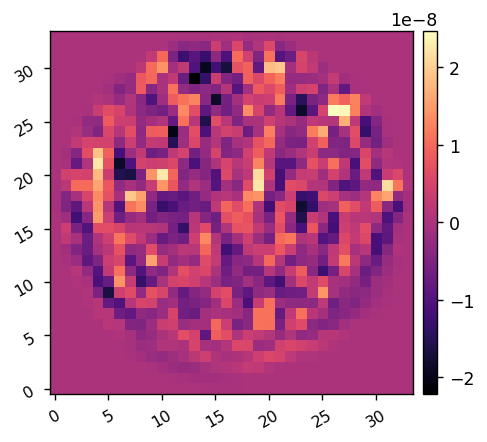

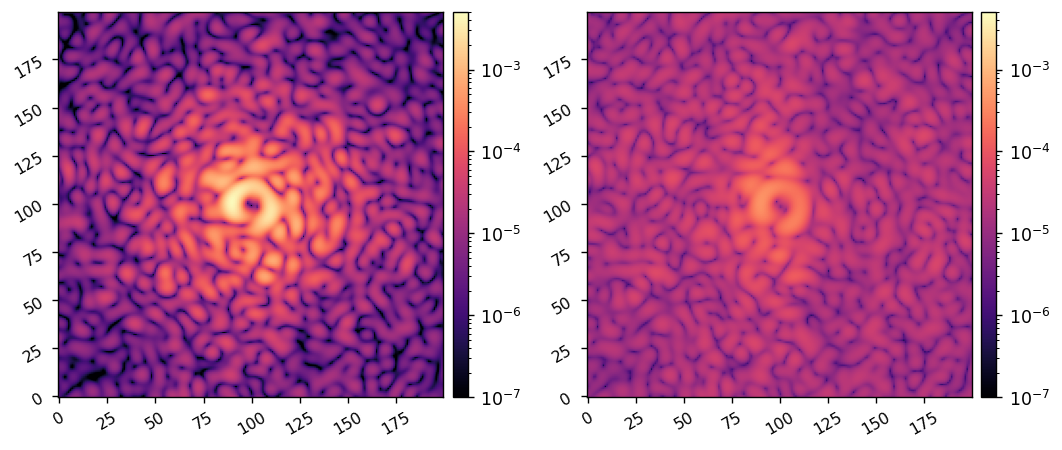

In [38]:
min_command = xp.zeros((Nact,Nact))
min_command[dm_mask] = res.x
coro_im = xp.abs(forward_model(res.x, use_wfe=True))/I_max_ref

print(xp.mean(ref_coro_im[control_mask]), xp.mean(coro_im[control_mask]))
imshow1(min_command)
imshow2(ref_coro_im, coro_im, lognorm=True, vmin1=1e-7, vmin2=1e-7, vmax1=5e-3, vmax2=5e-3)

# Test the generation of EFC probes with the adjoint model. 

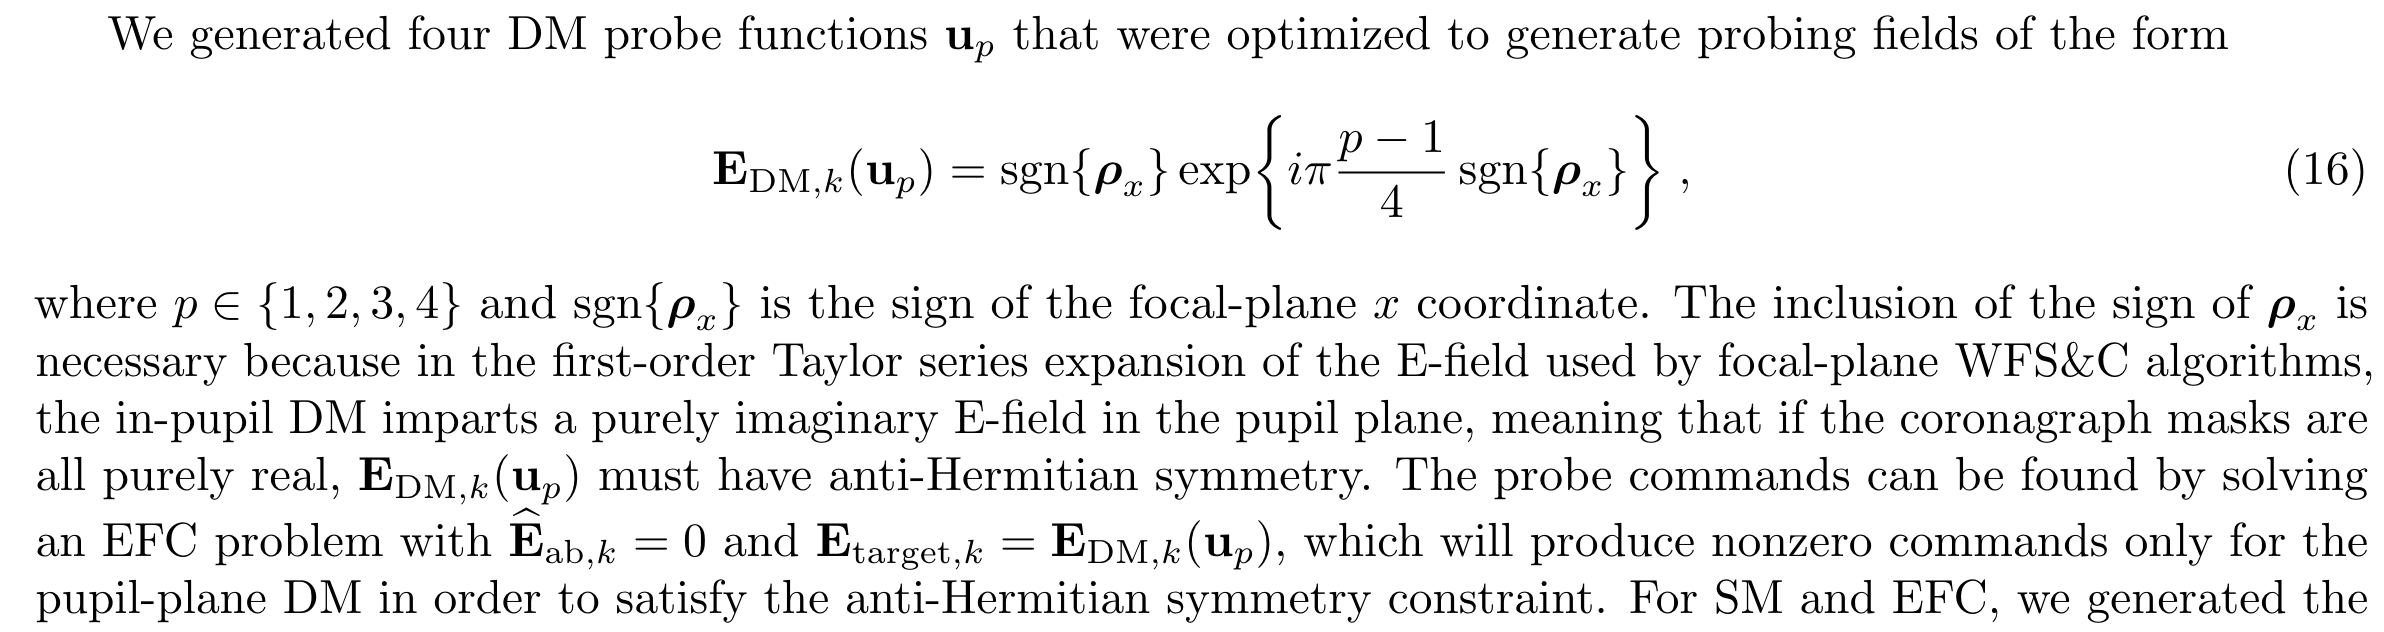

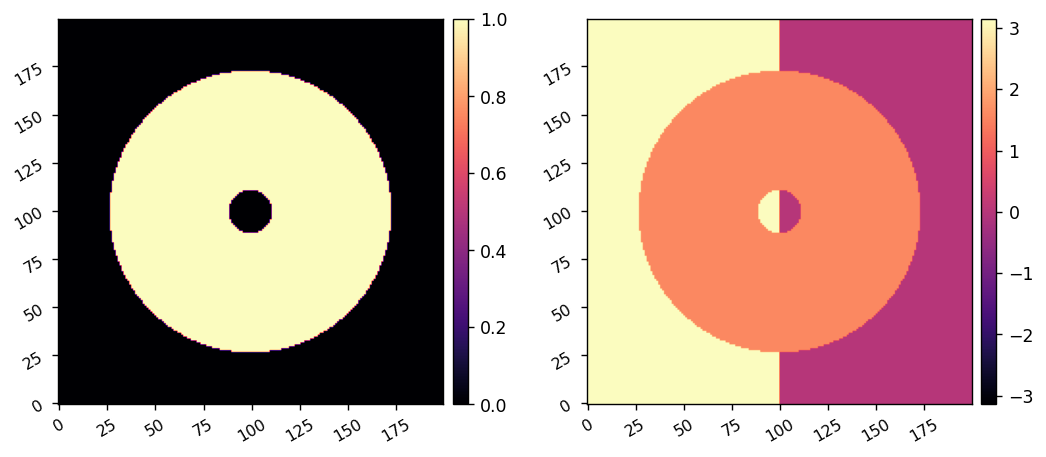

In [40]:
p = 3
probe_mask = ad_scoob.create_control_mask(npsf, psf_pixelscale_lamD, iwa=2, owa=13, edge=None)

x = (xp.linspace(-npsf/2, npsf/2-1, npsf) + 1/2)*psf_pixelscale_lamD
px,py = xp.meshgrid(x,x)
E_dm_probe = xp.sign(px) * xp.exp(1j * xp.pi * (p-1)/4 * xp.sign(px)) * probe_mask
imshow2(xp.abs(E_dm_probe), xp.angle(E_dm_probe), vmin2=-np.pi, vmax2=np.pi)

current_acts = np.zeros(Nacts)
del_acts = np.zeros(Nacts)
E_ab = 0
E_target = E_dm_probe

In [42]:
del_acts = np.zeros(Nacts)
E_ab = np.zeros((npsf,npsf))
E_target = 1e-4 * E_dm_probe
E_model_nom = ensure_np_array(forward_model(xp.zeros((Nacts)), use_vortex=True, use_wfe=False) / xp.sqrt(I_max_ref))
r_cond = 1e-2

bfgs_tol = 1e-3
bfgs_opts = {
    'maxiter':20,
    # 'maxls':30, # default is 20
    'ftol':1e-6, 
    'gtol':1e-6,
    'disp':True, 
}

del_acts0 = np.zeros(Nacts)
res = minimize(val_and_grad, 
                jac=True, 
                x0=del_acts0,
                args=(E_ab, E_target, E_model_nom, r_cond), 
                method='L-BFGS-B',
                #    method='CG',
                tol=bfgs_tol,
                options=bfgs_opts,
                )

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          952     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.89000D-05    |proj g|=          NaN


 This problem is unconstrained.



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  952      1     21      1     0     0         NaN   4.890D-05
  F =   4.8899999999999996E-005

ABNORMAL_TERMINATION_IN_LNSRCH                              
